In [1]:
# check whether RF experiments can reproduce paper results
# check whether figures are exactly reproduced

# make optimised sort and slice feature extractor function (how break ties, how atom invariants, ...)

# design readme file and embedd figures
# link to the paper in readme file
# give instructions/code/functions on how to easily use sort and slice in other projects


# ideas:
# research project: extract features from target space to see if it improves out-of-distribution-generalisation
# generate ecfps that are calibrated to entire chemical space (paper of all molecules)


# check whether in atom_id_to_support_list[atom_id][k] = 1 if current_atom_id_to_count_dict[atom_id > 0 else 0 the second part is unnecessary, simplify for atom_id in current_atom_id_to_count.keys(): atom_id_to_support_list[atom_id][k] = 1 further

In [15]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit.DataStructs.cDataStructs import UIntSparseIntVect

In [17]:
def construct_sort_and_slice_ecfp_featuriser(mols_train, 
                                             max_radius = 2, 
                                             pharm_atom_invs = False, 
                                             bond_invs = True, 
                                             chirality = False, 
                                             sub_counts = False, 
                                             vec_dimension = 1024):
    """
    Creates a function "ecfp_featuriser" that maps RDKit mol objects to vectorial ECFP fingerprints pooled via Sort & Slice (instead of traditional hash-based folding for substructure pooling).
    See also "Sort & Slice: A Simple and Superior Alternative to Hash-Based Folding for Extended-Connectivity Fingerprints" by Dablander, Hanser, Lambiotte and Morris (2024): https://arxiv.org/abs/2403.17954.
    
    INPUTS:
    
    - mols_train (list)        ...    A list of RDKit mol objects [mol_1, mol_2, ...] that are used as the training set to calibrate the Sort & Slice substructure pooling operator.
    - max_radius (int)         ...    The maximal radius up to which to generate the hashed integer ECFP-substructure identifiers. Common choices are 1, 2 or 3 (corresponding to diameters of 2, 4, or 6).
    - pharm_atom_invs (bool)   ...    If False, then the standard initial atomic invariants from RDKit (including ring membership) are used to generate the ECFPs; if True, then instead binary pharmacophoric initial atomic invariants are used to generate what is referred to as FCFPs.
    - bond_invs (bool)         ...    Whether or not to take into account bond invariants when generating the hashed integer ECFP-substructure identifiers (default = True).
    - chirality (bool)         ...    Whether or not to take into account chirality when generating the hashed integer ECFP-substructure identifiers (default = False).
    - sub_counts (bool)        ...    Whether ecfp_featuriser should generate binary vectorial fingerprints (sub_counts = False) that indicate the mere presence or absence of substructures, or integer fingerprints (sub_counts = True) that additionally indicate how many times a substructure is found in the input compound.
    - vec_dimension (int)      ...    Length of the vectorial Sort & Slice ECFP. Common choices are 512, 1024, 2048 and 4096. Only the vec_dimension most prevalent ECFP-substructures in mols_train are included in the final vector representation.
    
    OUTPUT:
    
    - ecfp_featuriser (function)    ...    A function that maps RDKit mol objects to vectorial ECFP fingerprints pooled via a Sort & Slice operator trained on mols_train.
    
    EXAMPLE:
    
    First construct a molecular featurisation function with desired settings via
    
    ecfp_featuriser = construct_sort_and_slice_ecfp_featuriser(mols_train = [mol_1, mol_2, ...], 
                                                               max_radius = 2, 
                                                               pharm_atom_invs = False, 
                                                               bond_invs = True, 
                                                               chirality = False, 
                                                               sub_counts = False, 
                                                               vec_dimension = 1024)
                                                               
    Note that the ECFP settings (max_radius, pharm_atom_invs, bond_invs, chirality, sub_counts, vec_dimension) and chemical information from mols_train are all by construction implicitly transferred to "ecfp_featuriser".
    
    Let mol be an RDKit mol object. Then ecfp_featuriser(mol) = np.array([1, 0, 0, ..., 1, 1, 0]) is a 1-dimensional numpy array of length "vec_dimension" representing the vectorial Sort & Slice ECFP fingerprint for mol.
    
    The fingerprint ecfp_featuriser(mol) is generated by (i) first generating the (multi)set of hashed integer ECFP-substructure identifiers from mol and then (ii) vectorising it via the Sort & Slice operator trained on mols_train (rather than vectorising it via classical hash-based folding).
    """
    
    # create substructure enumerator function that maps a mol object to a dictionary whose keys are all the integer ECFP-substructure identifiers identified in mol and whose values are the associated substructure counts in mol (i.e., how often each substructure appears in mol)
    morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius = max_radius,
                                                                 atomInvariantsGenerator = rdFingerprintGenerator.GetMorganFeatureAtomInvGen() if pharm_atom_invs == True else rdFingerprintGenerator.GetMorganAtomInvGen(includeRingMembership = True),
                                                                 useBondTypes = bond_invs,
                                                                 includeChirality = chirality)
    
    substructure_enumerator = lambda mol: morgan_generator.GetSparseCountFingerprint(mol).GetNonzeroElements()
    
    
    
    
    
    
    
    
    # construct support lists for integer ECFP-substructure identifier; the support list of a given ECFP-substructure identifier is a binary list of len(mols_train) whose i-th entry specifies whether the identifier is contained in mol_i
    atom_id_to_support_list = defaultdict(lambda: [0]*len(mols_train))

    for (k, mol) in enumerate(mols_train):
        for (atom_id, count) in substructure_enumerator(mol).items():
            atom_id_to_support_list[atom_id][k] = 1
            
    
    
    
    
    
    
    
    
    
    
    
    print("Number of unique circular substructures with specified parameters in molecular training data set = ", len(atom_id_to_support_list.keys()))
    
    # create list of atom ids sorted by prevalence in mols_train (ties are either broken using the arbitrary ordering induced via sorted(list(...), ...) or the arbitrary ordering induced by the integer atom ids themselves)
    atom_id_list_sorted = sorted(atom_id_to_support_list.keys(), key = lambda atom_id: (sum(atom_id_to_support_list[atom_id]), -atom_id), reverse = True)
    
    # create auxiliary one-hot encoder
    def one_hot_vec(dim, k):

        vec = np.zeros(dim)
        vec[k] = 1

        return vec.astype(int)
    
    # create integer substructure identifier (= atom id) one-hot embedding
    def atom_id_one_hot_encoder(atom_id):
        
        return one_hot_vec(fp_dimension, atom_id_list_sorted.index(atom_id)) if atom_id in atom_id_list_sorted[0: fp_dimension] else np.zeros(fp_dimension)
    
    def ecfp_featuriser(mol):

        
        # create list of integer substructure identifiers (= atom ids) in SMILES string (multiplied by their frequencies if ecfp_settings["counts"] = True)
        atom_id_list = []
        for (atom_id, count) in substructure_enumerator(mol).items():
            atom_id_list += [atom_id]*count

        # create a representation of the input compound as a (multi)set of one-hot encoded substructure emebeddings
        vector_multiset = np.array([atom_id_one_hot_encoder(atom_id) for atom_id in atom_id_list])
        
        # sum up one-hot encoded substructure embeddings to create molecule-wide representation
        ecfp_vector = np.sum(vector_multiset, axis = 0)
    
        return ecfp_vector
    
    return ecfp_featuriser

In [86]:
mols_train = [Chem.MolFromSmiles(smiles) for smiles in x_smiles[:100]]

mols_test = [Chem.MolFromSmiles(smiles) for smiles in x_smiles[-100:]]

In [88]:
%%time
ecfp_featuriser = construct_sort_and_slice_ecfp_featuriser(mols_train[0:1], 
                                                           max_radius = 2, 
                                                           atom_inv_type = "ecfp", 
                                                           bond_invs = True, 
                                                           chirality = False, 
                                                           counts = True, 
                                                           fp_dimension = 1024)

(98513984, 2)
(217272578, 1)
(409801989, 1)
(434423882, 2)
(643572069, 1)
(751549370, 1)
(755401219, 1)
(951226070, 6)
(963029399, 1)
(966311396, 2)
(1016841875, 1)
(1101907775, 1)
(1147977085, 1)
(1163692816, 1)
(1634606847, 1)
(2041434490, 1)
(2089117413, 1)
(2092489639, 3)
(2231814927, 1)
(2245384272, 1)
(2246340824, 1)
(2246728737, 1)
(2473389857, 1)
(2604440622, 1)
(2803848648, 4)
(2968968094, 4)
(2975126068, 1)
(3002759401, 2)
(3011672423, 1)
(3182824521, 1)
(3217380708, 5)
(3218693969, 8)
(3452535345, 1)
(3657471097, 1)
(3777243454, 1)
(3820826669, 1)
(3848534832, 2)
(3999906991, 2)
(4261830945, 1)
(4265716399, 1)
Number of unique circular substructures with specified parameters in molecular training data set =  40
CPU times: user 5.08 ms, sys: 0 ns, total: 5.08 ms
Wall time: 4.09 ms


In [116]:
atom_inv_type = "ecfp"

In [121]:
rdFingerprintGenerator.GetMorganAtomInvGen(includeRingMembership = True) if atom_inv_type == "ecfp" else rdFingerprintGenerator.GetMorganFeatureAtomInvGen()

In [117]:
morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius = 2, includeChirality = True, useBondTypes = True, atomInvariantsGenerator = rdFingerprintGenerator.GetMorganAtomInvGen(includeRingMembership = True) if atom_inv_type == "ecfp" else rdFingerprintGenerator.GetMorganFeatureAtomInvGen() if atom_inv_type == "fcfp")
substructure_enumerator = lambda mol: morgan_generator.GetSparseCountFingerprint(mol).GetNonzeroElements()


SyntaxError: invalid syntax (<ipython-input-117-9c63275cdada>, line 1)

In [114]:
substructure_enumerator(mols_train[0])

{98513984: 2,
 217272578: 1,
 409801989: 1,
 434423882: 2,
 643572069: 1,
 751549370: 1,
 755401219: 1,
 951226070: 6,
 963029399: 1,
 966311396: 2,
 1016841875: 1,
 1101907775: 1,
 1147977085: 1,
 1163692816: 1,
 1634606847: 1,
 2041434490: 1,
 2089117413: 1,
 2092489639: 3,
 2231814927: 1,
 2245384272: 1,
 2246340824: 1,
 2246728737: 1,
 2473389857: 1,
 2604440622: 1,
 2803848648: 4,
 2968968094: 4,
 2975126068: 1,
 3002759401: 2,
 3011672423: 1,
 3182824521: 1,
 3217380708: 5,
 3218693969: 8,
 3452535345: 1,
 3657471097: 1,
 3777243454: 1,
 3820826669: 1,
 3848534832: 2,
 3999906991: 2,
 4261830945: 1,
 4265716399: 1}

# Import Packages

In [1]:
# import general packages and set general options
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
import warnings
warnings.filterwarnings("ignore")

# import custom code written for this project
from modules import *

# import and check funtionality of pytorch
import torch
print("Pytorch version = ", torch.__version__)
print("CUDA version = ", torch.version.cuda)
print("CUDA available = ", torch.cuda.is_available())
print("Random Pytorch test tensor = ", torch.rand(1))

Pytorch version =  1.10.2+cu113
CUDA version =  11.3
CUDA available =  False
Random Pytorch test tensor =  tensor([0.5256])


# Load and Prepare Data

In [2]:
# initialise dictionary used to store experimental settings, after dictionary is initialised, choose one of the five data sets below to proceed

settings_dict = {}

In [3]:
# LIT-PCBA Estrogen Receptor Alpha Antagonism

settings_dict["dataset_name"] = "lit_pcba_esr_ant"
settings_dict["task_type"] = "classification"
settings_dict["prop_name"] = "Activity"

In [9]:
# MoleculeNet Lipophilicity

settings_dict["dataset_name"] = "moleculenet_lipophilicity"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "exp"

In [7]:
# AqSolDB solubility

settings_dict["dataset_name"] = "aqsoldb_solubility"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "Solubility"

In [3]:
# PostEra SARS-CoV-2 Mpro inhibition

settings_dict["dataset_name"] = "postera_sars_cov_2_mpro"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "f_avg_IC50"

In [33]:
# Ames mutagenicity

settings_dict["dataset_name"] = "ames_mutagenicity"
settings_dict["task_type"] = "classification"
settings_dict["prop_name"] = "Activity"

In [4]:
# load clean data

dataframe = pd.read_csv("data/" + settings_dict["dataset_name"] + "/" + "clean_data.csv", sep = ",")
display(dataframe)

SMILES  Activity
0            CN(C(=O)CCCOc1ccc2[nH]c(=O)ccc2c1)C1CCCCC1         1
1     C[C@@H]1O[C@@H](O[C@@H]2C=C3CC[C@@H]4[C@H](CC[...         1
2             COc1ccc2cc3-c4cc5c(cc4CC[n+]3cc2c1OC)OCO5         1
3                               N=C(N)NC(=N)NCCc1ccccc1         1
4     CC(=O)N1CCN(c2ccc(OC[C@H]3CO[C@](Cn4ccnc4)(c4c...         1
...                                                 ...       ...
3916       CN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1         0
3917    Cc1cc(N)c2cc(NC(=O)Nc3ccc4nc(C)cc(N)c4c3)ccc2n1         0
3918                                NC(Cc1ccccc1)C(=O)O         0
3919    C=C[C@H]1CN2CCC1C[C@@H]2[C@@H](O)c1ccnc2ccccc12         0
3920       CC1(C)[C@@H]2CC[C@@]1(C)[C@H](OC(=O)CSC#N)C2         0

[3921 rows x 2 columns]

Mean Value (Target) =  0.022443254271869422
Standard Deviation (Target) =  0.14812006822020315
Maximum Value (Target) =  1.0
Minimum Value (Target) =  0.0 

Shape of y =  (3921,)

 y =  [1. 1. 1. ... 0. 0. 0.]


(array([3833.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          88.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

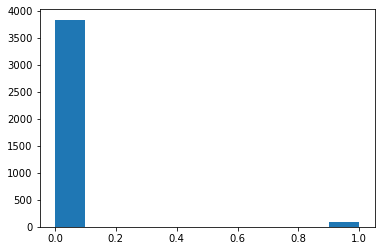

In [5]:
# construct target variable y (for the SARS-CoV-2 main protease data set, we convert Ki to pKi by taking negative decadic logarithm)

if settings_dict["dataset_name"] == "postera_sars_cov_2_mpro":
    y = -np.log10(dataframe.loc[:, settings_dict["prop_name"]].values.astype(float))
else:
    y = dataframe.loc[:, settings_dict["prop_name"]].values.astype(float)

print("Mean Value (Target) = ", np.mean(y))
print("Standard Deviation (Target) = ", np.std(y))
print("Maximum Value (Target) = ", np.amax(y))
print("Minimum Value (Target) = ", np.amin(y), "\n")

print("Shape of y = ", y.shape)
print("\n y = ", y)

plt.hist(y)

Shape of x_smiles =  (3921,)
CN(C(=O)CCCOc1ccc2[nH]c(=O)ccc2c1)C1CCCCC1


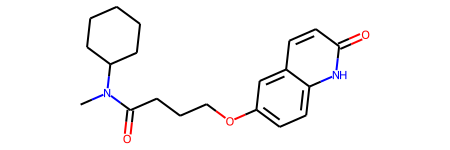

In [6]:
# extract SMILES strings

x_smiles = np.reshape(dataframe["SMILES"].values, (len(dataframe), 1))[:,0]

print("Shape of x_smiles = ", x_smiles.shape)
print(x_smiles[0])
display(Chem.MolFromSmiles(x_smiles[0]))

In [7]:
# create dictionary that maps smiles strings to their target values

x_smiles_to_y_dict = dict(list(zip(x_smiles, y)))

# Prepare Data Split

In [8]:
# choose settings for dictionary that contains indices for data splits

settings_dict["split_type"] = "scaff" # choose "rand" for random split and "scaff" for scaffold split
settings_dict["split_type_rand_stratified"] = False # given a random split and a classification problem, choose whether to stratify the split
settings_dict["k_splits"] = 2 # choose number of cross validation folds k_splits
settings_dict["m_reps"] = 3 # choose number of random seeds m_reps with which the cross validation scheme is repeated
settings_dict["random_state_cv"] = 42 # choose random state

In [9]:
# construct dictionary that contains indices for data splits

if settings_dict["split_type"] == "rand" and settings_dict["split_type_rand_stratified"] == False:
    
    data_split_dict = create_data_split_dict_random(x_smiles = x_smiles,
                                                    k_splits = settings_dict["k_splits"],
                                                    m_reps = settings_dict["m_reps"],
                                                    random_state_cv = settings_dict["random_state_cv"])

elif settings_dict["split_type"] == "rand" and settings_dict["split_type_rand_stratified"] == True:
    
    data_split_dict = create_data_split_dict_random_strat(x_smiles = x_smiles,
                                                          y = y,
                                                          k_splits = settings_dict["k_splits"],
                                                          m_reps = settings_dict["m_reps"],
                                                          random_state_cv = settings_dict["random_state_cv"])
    
elif settings_dict["split_type"] == "scaff":
    
    data_split_dict = create_data_split_dict_scaffold(x_smiles = x_smiles,
                                                      k_splits = settings_dict["k_splits"],
                                                      m_reps = settings_dict["m_reps"],
                                                      scaffold_func = "Bemis_Murcko_generic",
                                                      random_state_cv = settings_dict["random_state_cv"])

# Evaluate Models

In [10]:
# choose ECFP hyperparameters

settings_dict["ecfp_settings"] = {"mol_to_invs_function": ecfp_invariants, # ecfp_invariants or fcfp_invariants
                                  "radius": 2, # 0 or 1 or 2 or 3 ...
                                  "pool_method": "sort_and_slice", # "hashed" or "sort_and_slice" or "filtered" or "mim"
                                  "dimension": 1024, # 256 or 512 or 1024 or 2048 or 4096 ...
                                  "use_bond_invs": True, # True or False
                                  "use_chirality": True, # True or False
                                  "use_counts": False} # True or False

In [11]:
# chose ml model: random forest or multilayer perceptron

settings_dict["ml_model"] = "rf" # "rf" or "mlp"

In [12]:
# choose rf hyperparameters

settings_dict["rf_settings"] = {"n_estimators" : 100,
                                "max_depth" : None,
                                "min_samples_leaf" : 1,
                                "min_samples_split" : 2,
                                "bootstrap" : True,
                                "max_features": "sqrt",
                                "random_state" : 42}

if settings_dict["task_type"] == "regression":

    settings_dict["rf_settings"]["criterion"] = "squared_error"

elif settings_dict["task_type"] == "classification":

    settings_dict["rf_settings"]["criterion"] = "gini"

In [13]:
# choose mlp hyperparameters

settings_dict["mlp_settings"] = {"architecture" : list(arch(settings_dict["ecfp_settings"]["dimension"], 1, 512, 5)),
                                "hidden_activation" : nn.ReLU(),
                                "use_bias" : True,
                                "hidden_dropout_rate" : 0.25,
                                "hidden_batchnorm" : True,
                                "batch_size" : 64,
                                "dataloader_shuffle" : True,
                                "dataloader_drop_last" : True,
                                "learning_rate" : 1e-3,
                                "lr_lambda" : lambda epoch: max(0.98**epoch, 1e-2),
                                "lr_last_epoch": 0,
                                "weight_decay" : 0.1,
                                "num_epochs" : 0,
                                "optimiser" : torch.optim.AdamW,
                                "print_results_per_epochs" : None}

if settings_dict["task_type"] == "regression":

    settings_dict["mlp_settings"]["output_activation"] = nn.Identity()
    settings_dict["mlp_settings"]["loss_function"] = nn.MSELoss()
    settings_dict["mlp_settings"]["performance_metrics"] = "regression"

elif settings_dict["task_type"] == "classification":

    settings_dict["mlp_settings"]["output_activation"] = nn.Sigmoid()
    settings_dict["mlp_settings"]["loss_function"] = nn.BCELoss()
    settings_dict["mlp_settings"]["performance_metrics"] = "classification"

In [14]:
%%time
# run model and save results

# dictionary to save results over the k_splits-fold cross validation with m_reps random seeds
scores_dict = {}

# ind_train and ind_test contain the indices for the data split corresponding to the k-th fold with the m-th random seed
for ((m, k), (ind_train, ind_test)) in data_split_dict.items():
    
    # create ecfp featuriser
    featuriser = create_ecfp_featuriser(ecfp_settings = settings_dict["ecfp_settings"], 
                                        x_smiles_train = x_smiles[ind_train], 
                                        y_train = y[ind_train], 
                                        discretise_y = True if settings_dict["task_type"] == "regression" else False,
                                        base = 2, 
                                        random_state = 42)
    
    # create ecfp-based feature matrices
    X_train = featuriser(x_smiles[ind_train])
    X_test = featuriser(x_smiles[ind_test])

    # create ml model + train ml model + make predictions on test set
    if settings_dict["ml_model"] == "rf":
        
        rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"])
        rf_model.fit(X_train, y[ind_train])
        y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])
        
    if settings_dict["ml_model"] == "mlp":
        
        mlp_model = create_mlp_model(settings_dict["mlp_settings"])
        (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y[ind_train], X_test, y[ind_test])
        plt.plot(loss_curve_train)
        plt.plot(loss_curve_test)
        y_test_pred = make_mlp_prediction(mlp_model, X_test)
        
    # record scores
    print(m, k)
    if settings_dict["task_type"] == "regression":
        scores_dict[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = True)
    elif settings_dict["task_type"] == "classification":
        scores_dict[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = True)
        
# summarise, display and save scores for this experiment
summarise_display_and_save_results_and_settings(scores_dict, settings_dict, display_results = True)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
Scores:  0.158085  0.757459  0.975976           0.499692       0.0 -0.003797   

         Sensitivity  Specificity  Precision  Negative Predictive Value  \
Scores:          0.0     0.999385        0.0                   0.976562   

         Test Cases  Negative Test Cases  Positive Test Cases  
Scores:      1665.0               1626.0                 39.0

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
Scores:  0.09559  0.611246   0.97828           0.519955  0.075472  0.138283   

         Sensitivity  Specificity  Precision  Negative Predictive Value  \
Scores:     0.040816     0.999094        0.5                    0.97913   

         Test Cases  Negative Test Cases  Positive Test Cases  
Scores:      2256.0               2207.0                 49.0

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
Scores:  0.08692  0.715573  0.973926           0.509541  0.037736  0.095148   

         Sensitivity  Specificity  Precision  Negative Predictive Value  \
Scores:     0.019608     0.999475        0.5                   0.974411   

         Test Cases  Negative Test Cases  Positive Test Cases  
Scores:      1956.0               1905.0                 51.0

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
Scores:  0.049034  0.631035  0.980662           0.499741       0.0 -0.003126   

         Sensitivity  Specificity  Precision  Negative Predictive Value  \
Scores:          0.0     0.999481        0.0                   0.981161   

         Test Cases  Negative Test Cases  Positive Test Cases  
Scores:      1965.0               1928.0                 37.0

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score  MCC  \
Scores:  0.066053  0.624382  0.968383                0.5       0.0  0.0   

         Sensitivity  Specificity  Precision  Negative Predictive Value  \
Scores:          0.0          1.0        NaN                   0.968383   

         Test Cases  Negative Test Cases  Positive Test Cases  
Scores:      1961.0               1899.0                 62.0

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score      MCC  \
Scores:  0.029743  0.599773  0.985204           0.499224       0.0 -0.00454   

         Sensitivity  Specificity  Precision  Negative Predictive Value  \
Scores:          0.0     0.998449        0.0                   0.986714   

         Test Cases  Negative Test Cases  Positive Test Cases  
Scores:      1960.0               1934.0                 26.0

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.158085  0.757459  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.095590  0.611246  0.978280           0.519955  0.075472  0.138283   
(1, 0)  0.086920  0.715573  0.973926           0.509541  0.037736  0.095148   
(1, 1)  0.049034  0.631035  0.980662           0.499741  0.000000 -0.003126   
(2, 0)  0.066053  0.624382  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.029743  0.599773  0.985204           0.499224  0.000000 -0.004540   
mean    0.080904  0.656578  0.977072           0.504692  0.018868  0.036995   
std     0.040952  0.058635  0.005277           0.007723  0.028821  0.057747   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.040816     0.999094   0.500000                   0.979130   
(1, 0)     0.019608     0.999475   0.500000                   0.974411   
(1, 1)     0.000000     0.999481   0.000000                   0.981161   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.000000     0.998449   0.000000                   0.986714   
mean       0.010071     0.999314   0.200000                   0.977727   
std        0.015502     0.000470   0.244949                   0.005689   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

CPU times: user 48.6 s, sys: 7.94 s, total: 56.6 s
Wall time: 51.7 s


In [18]:
%%time
# run full battery of experiments for one data set and data splitting type with both rfs and mlps

# first clear folder from previous experimental results
delete_all_files_in_folder("results/" + settings_dict["dataset_name"] + "/" + settings_dict["split_type"] + "/")

for pool_method in ["hashed", "filtered", "mim", "sort_and_slice"]:
    for dimension in [512, 1024, 2048, 4096]:
        for inv_func in [ecfp_invariants, fcfp_invariants]:
            for radius in [1, 2, 3]:

                print("pool_method = ", pool_method)
                print("dimension = ", dimension)
                print("inv_func = ", inv_func)
                print("radius = ", radius, "\n")

                # choose ECFP hyperparameters
                settings_dict["ecfp_settings"] = {"mol_to_invs_function": inv_func,
                                                  "radius": radius,
                                                  "pool_method": pool_method,
                                                  "dimension": dimension,
                                                  "use_bond_invs": True,
                                                  "use_chirality": True,
                                                  "use_counts": False}

                # run rf- and mlp models and save results
                scores_dict_rf = {}
                scores_dict_mlp = {}

                # ind_train and ind_test contain the indices for the data split corresponding to the k-th fold with the m-th random seed
                for ((m, k), (ind_train, ind_test)) in data_split_dict.items():
                    
                    # create ecfp featuriser
                    featuriser = create_ecfp_featuriser(ecfp_settings = settings_dict["ecfp_settings"], 
                                                        x_smiles_train = x_smiles[ind_train], 
                                                        y_train = y[ind_train], 
                                                        discretise_y = True if settings_dict["task_type"] == "regression" else False,  
                                                        base = 2, 
                                                        random_state = 42)

                    # create ecfp-based feature matrices
                    X_train = featuriser(x_smiles[ind_train])
                    X_test = featuriser(x_smiles[ind_test])
                    
                    # create rf model + train ml model + make predictions on test set
                    rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"])
                    rf_model.fit(X_train, y[ind_train])
                    y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])

                    # record rf scores
                    print(m, k, "rf")
                    if settings_dict["task_type"] == "regression":
                        scores_dict_rf[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = False)
                    elif settings_dict["task_type"] == "classification":
                        scores_dict_rf[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = False)
                    
                    # create mlp model + train ml model + make predictions on test set
                    settings_dict["mlp_settings"]["architecture"][0] = dimension
                    mlp_model = create_mlp_model(settings_dict["mlp_settings"])
                    (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y[ind_train], X_test, y[ind_test])
                    y_test_pred = make_mlp_prediction(mlp_model, X_test)

                    # record mlp scores
                    print(m, k, "mlp")
                    if settings_dict["task_type"] == "regression":
                        scores_dict_mlp[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = False)
                    elif settings_dict["task_type"] == "classification":
                        scores_dict_mlp[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = False) 
                    
                # summarise, display and save scores for this experiment
                settings_dict["ml_model"] = "rf"
                summarise_display_and_save_results_and_settings(scores_dict_rf, settings_dict, display_results = True)
                settings_dict["ml_model"] = "mlp"
                summarise_display_and_save_results_and_settings(scores_dict_mlp, settings_dict, display_results = True)
                print("\n \n \n")

NameError: name 'a' is not defined

# Results Visualisation

Dataset names:

    "ames_mutagenicity",
    "aqsoldb_solubility",
    "lit_pcba_esr_ant",
    "moleculenet_lipophilicity",
    "postera_sars_cov_2_mpro".
    
Available classification metrics: 

    "PRC-AUC",
    "AUROC", 
    "Accuracy", 
    "Balanced Accuracy", 
    "F1-Score", 
    "MCC", 
    "Sensitivity", 
    "Specificity", 
    "Precision", 
    "Negative Predictive Value", 
    "Test Cases", 
    "Negative Test Cases", 
    "Positive Test Cases".

Available regression metrics:

    "MAE", 
    "MedAE", 
    "RMSE", 
    "MaxAE", 
    "MSE", 
    "PearsonCorr", 
    "R2Coeff", 
    "Test Cases".

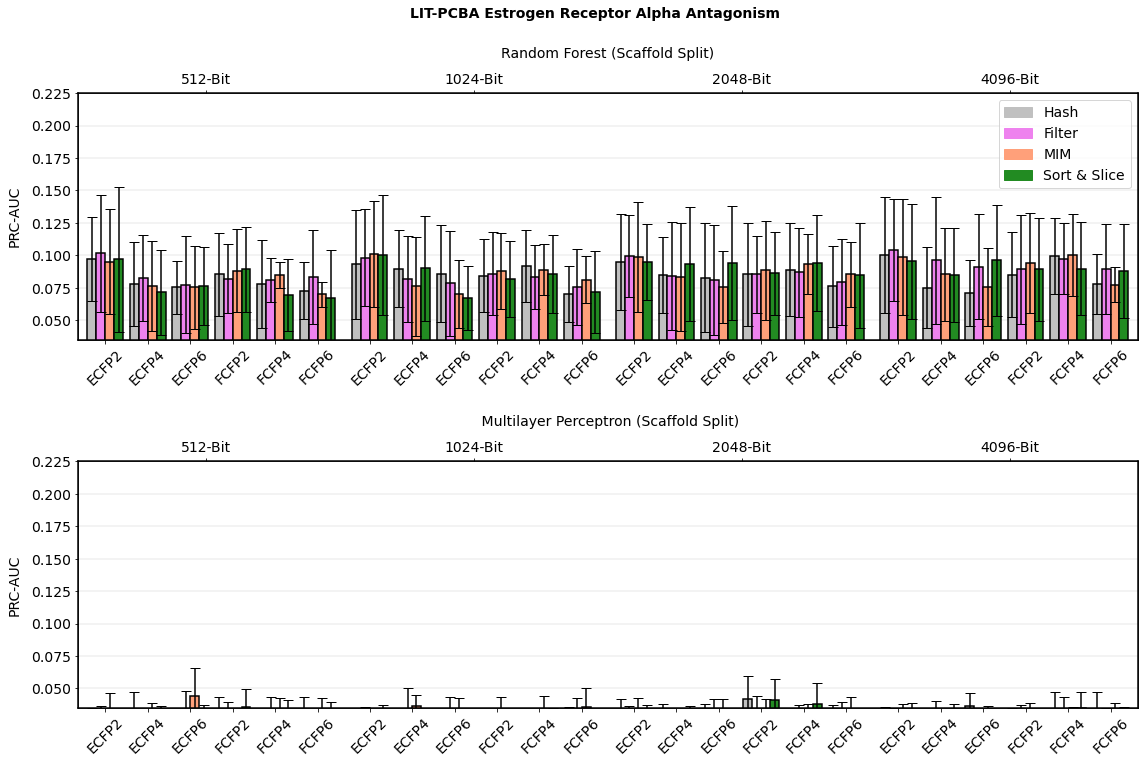

In [17]:
visualise_bar_charts(dataset_name = "lit_pcba_esr_ant", # specify dataset name
                     split_type = "scaff", # specify split type "rand" or "scaff" (for random or scaffold split)
                     metric = "PRC-AUC", # specify performance metric,
                     y_lims = (0.04, 0.22), # specify limits of y-axis
                     y_unit = "") # specify unit for y-axis (if applicable)

[0.16213318 0.16901611 0.15891891 0.17237188]
[0.01788898 0.0153089  0.01780919 0.01422271] 

[0.0291579  0.03050296 0.03092159 0.03082153]
[0.00299817 0.00365079 0.00403482 0.0053163 ] 

[0.08423569 0.0858784  0.08317475 0.08674594]
[0.00871132 0.00578098 0.00933342 0.00968227] 

[0.05868495 0.02846447 0.05691309 0.06029368]
[0.00900185 0.0027575  0.00966824 0.00884483] 



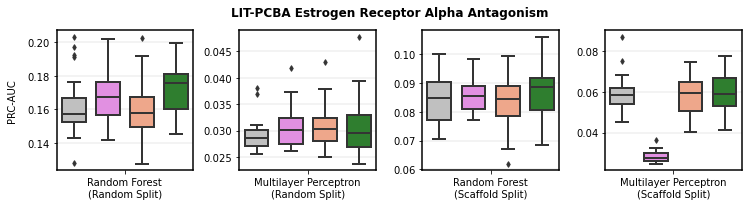

In [26]:
visualise_box_plots(dataset_name = "lit_pcba_esr_ant", # specify dataset name
                    metric = "PRC-AUC", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not